In [14]:
# libraries
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [2]:
# implement Neural Network
def fit_NeuralNetwork(X_train, y_train, alpha, hidden_layer_sizes, epochs):
    # initialize the epoch errors
    err = np.zeros((epochs, 1))

    # initialize the architecture
    N, d = X_train.shape
    X0 = np.ones((N, 1))
    X_train = np.hstack((X0, X_train))
    d = d + 1
    L = len(hidden_layer_sizes)
    L = L + 2

    # initializing the weights for input layer
    weight_layer = np.random.normal(0, 0.1, (d, hidden_layer_sizes[0]))
    weights = []
    weights.append(weight_layer)

    # initializing the weights for hidden layers
    for l in range(L - 3):
        weight_layer = np.random.normal(0, 0.1, (hidden_layer_sizes[l] + 1, hidden_layer_sizes[l + 1]))
        weights.append(weight_layer)

    # initializing the weights for output layers
    weight_layer = np.random.normal(0, 0.1, (hidden_layer_sizes[l + 1] + 1, 1))
    weights.append(weight_layer)

    # iterate through epochs
    for e in range(epochs):
        # shuffle indexes from 0 to N
        choiceArray = np.arange(0, N)
        np.random.shuffle(choiceArray)
        errN = 0
        for n in range(N):
            # get the input and output of the training set
            index = choiceArray[n]
            x = np.transpose(X_train[index])
            y_n = y_train[index]

            # find the output and input for all nodes in the neural network
            X, s = forwardPropagation(x, weights)

            # find the gradient descent using back propagation
            g = backPropagation(X, y_n, s, weights)

            # update to the new weights
            weights = updateWeights(weights, g, alpha)

            # calculate the total error
            errN += errorPerSample(X, y_n)

        # find the average error
        err[e] = errN / N

    # return the error and the weights
    return err, weights

In [3]:
# calculate output at all nodes (X) and input into all nodes (S)
def forwardPropagation(x, weights):
    # initialize
    l = len(weights) + 1
    currX = x
    retS = []
    retX = [currX]

    # forward propagate for each layer
    for i in range(l - 1):
        # calculate s using x and weights
        currS = np.dot(np.transpose(weights[i]), currX)
        currX = currS
        # append calculated s
        retS.append(currS.copy())

        # use the activation function of the other layers
        if i != len(weights) - 1:
            for j in range(len(currS)):
                # calculate x using the activation function
                currX[j]= activation(currS[j])
            # add the bias term
            currX= np.hstack((1, currX))
        # use the ouputf function for the last layer
        else:
            currX = outputf(currS)

        # append calculated x
        retX.append(currX)

    # return the output al all nodes and input into all nodes
    return retX, retS

In [4]:
# calculate the gradient descent for each layer
def backPropagation(X, y_n, s, weights):
    l = len(X)
    delL = []

    # Find the delL of the last layer
    delL.insert(0, derivativeError(X[l - 1], y_n) * derivativeOutput(s[l - 2]))

    # calculate dL/dS[l-2], dL/dS[l-3], ..., dL/dS[1]
    for i in range(l - 2, 0, -1):
        # get the next delL
        delNextLayer = delL[0]
        # remove the bias term of weights
        WeightsNextLayerWithoutBias = weights[i][1:]
        # get the current sum
        sCurrLayer = s[i - 1]

        # matrix multiplication of current delL and weights
        nextLayerCalc = np.dot(WeightsNextLayerWithoutBias, delNextLayer)

        # initialize new delL
        delN = np.zeros(len(sCurrLayer))

        # pointwise multiplication to calculate the new delL
        for j in range(len(sCurrLayer)):
          delN[j] = nextLayerCalc[j] * derivativeActivation(sCurrLayer[j])

        # insert newly calulated delL into delL
        delL.insert(0, delN)

    #initialize gradient descent
    g = []

    # calculate the gradient descents using delL
    for i in range(len(delL)):
        rows, cols = weights[i].shape
        gL = np.zeros((rows, cols))

        # matrix multiplication of X and delL
        for j in range(rows):
            for k in range(cols):
                gL[j, k] = X[i][j] * delL[i][k]
        # append calculated gradient descent
        g.append(gL)

    # return gradient descent
    return g

In [5]:
# find the error contributed at the last layer
def errorPerSample(X, y_n):
    # get the output of front propagation and output then find the error
    return errorf(X[-1][0], y_n)

In [6]:
# update the weights of every layer
def updateWeights(weights, g, alpha):
    # initialize the new weights
    nW = []

    for i in range(len(weights)):
        # get the current weights, shape and gradient descent for each layer
        rows, cols = weights[i].shape
        currWeight = weights[i].copy()
        currG = g[i]

        # loop through the rows and columns
        for j in range(rows):
            for k in range(cols):
                # update the current weight with alpha and the gradient descent
                currWeight[j, k] = currWeight[j, k] - alpha * currG[j, k]

        # append the new weight to the nW array
        nW.append(currWeight)

    # return the updated weights
    return nW

In [7]:
# ReLU activation function
def activation(s):
    return max(0, s)


# if s > 0 derivative of ReLU is 1 else 0
def derivativeActivation(s):
    return 1 if s > 0 else 0

In [8]:
# return sigmoid function
def outputf(s):
    return 1 / (1 + np.exp(-1 * s))


# return derivative of sigmoid function
def derivativeOutput(s):
    return outputf(s) ** 2 * np.exp(-1 * s)

In [9]:
# return log loss error function
def errorf(x_L, y):
    if y == 1:
        return -1 * np.log(x_L)
    else:
        return -1 * np.log(1 - x_L)


# return derivative of log loss error function
def derivativeError(x_L, y):
    if y == 1:
        return -1 / x_L
    else:
        return 1 / (1 - x_L)

In [10]:
# get the predictions from the neural network
def pred(x_n, weights):
    # find the output and input for all nodes in the neural network
    retX, retS = forwardPropagation(x_n, weights)
    l = len(retX)

    # return -1 if probability less than 0.5
    if retX[l - 1] < 0.5:
        return -1
    # return 1 if probability is greater or equal to 0.5
    else:
        return 1


# get the confusion matrix
def confMatrix(X_train, y_train, w):
    eCount = np.zeros((2, 2))
    row, col = X_train.shape
    X0 = np.ones((row, 1))
    X_train = np.hstack((X0, X_train))

    # calculate the confusion matrix
    for j in range(row):
        # True Negative
        if(pred(X_train[j], w) == -1 and y_train[j] == -1):
            eCount[0, 0] += 1
        # False Positive
        if(pred(X_train[j], w) == 1 and y_train[j] == -1):
            eCount[0, 1] += 1
        # True Positive
        if(pred(X_train[j], w) == 1 and y_train[j] == 1):
            eCount[1, 1] += 1
        # False Negative
        if(pred(X_train[j], w) == -1 and y_train[j] == 1):
            eCount[1, 0] += 1

    # return the confusion matrix
    return eCount

In [11]:
# plot the error using matplotlib
def plotErr(e, epochs):
    # plot the error as epochs increase
    plt.plot(e, linewidth = 2.0)
    plt.xlabel('Epochs')
    plt.ylabel('Error')

    # show the plot
    plt.show()

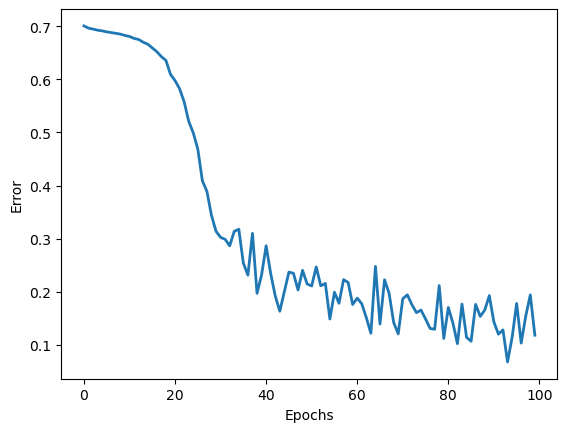

Confusion Matrix:
 [[ 7.  1.]
 [ 0. 12.]]


In [19]:
X_train, y_train = load_iris(return_X_y = True)
X_train, X_test, y_train, y_test = train_test_split(X_train[50:], y_train[50:], test_size = 0.2, random_state = 1)

# hyperparameters
alpha = 1e-2
hidden_layer_sizes = [30, 10]
num_epochs = 100

for i in range(80):
    if y_train[i] == 1:
        y_train[i] = -1
    else:
        y_train[i] = 1
for j in range(20):
    if y_test[j] == 1:
        y_test[j] = -1
    else:
        y_test[j] = 1

# find the error and weight using the neural network implemented above
err, w = fit_NeuralNetwork(X_train, y_train, alpha, hidden_layer_sizes, num_epochs)

# plot the error for the neural network implemented above
plotErr(err, num_epochs)

# calculate the confusion matrix for the neural network implemented above
cM = confMatrix(X_test, y_test, w)

# print the confusion matrices
print("Confusion Matrix:\n", cM)